# Optimizing a 15-Stock Portfolio 
#### By: Abbasali Panju

#### The following is a demontration of Harry Markowitz's Modern Portfolio Theory (MPT) to optimize a portfolio of 15 stocks based on the Sharpe Ratio. Since it's introduction in 1952, MPT has been utilized by successful asset managers around the world to build a diversified portoflio that seeks to maximize risk-adjusted returns. 

#### To conduct the optimization and calculate the necessary inputs, the PyPortfolioOpt Library was used. More information can be found at: https://pyportfolioopt.readthedocs.io/en/latest/index.html

Martin, R. A., (2021). PyPortfolioOpt: portfolio optimization in Python. Journal of Open Source Software, 6(61), 3066, https://doi.org/10.21105/joss.03066

### Importing Libraries

In [146]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Importing PyPortfolioOpt Library
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns

%matplotlib inline

### Assigning start_date/end_date and assets (using a 5-year period)

In [147]:
start_date, end_date = '01-01-2017','01-01-2022'

In [148]:
assets = ['AAPL','FB','NYT','LULU','FRPT','FIVE','CHGG','ENB','JPM','BMO','PFE','CP',
          'WCN','SQ','IRBT']

### Using Pandas DataReader to extract 'Adj Close' data from Yahoo Finance

In [149]:
df = web.DataReader(assets, 'yahoo', start_date, end_date)['Adj Close']
df.head()

Symbols,AAPL,FB,NYT,LULU,FRPT,FIVE,CHGG,ENB,JPM,BMO,PFE,CP,WCN,SQ,IRBT
Date,,,,,,,,,,,,,,,
2017-01-03,27.332474,116.860001,12.963237,66.849998,10.20,40.480000,7.35,32.612404,75.651817,60.812275,25.928757,26.923759,50.693890,13.81,57.580002
2017-01-04,27.301880,118.690002,13.204189,69.410004,10.50,40.689999,7.52,32.842392,75.791344,61.611874,26.156612,27.784220,51.690666,14.25,59.220001
2017-01-05,27.440716,120.669998,13.107808,68.730003,10.35,40.950001,7.56,33.225704,75.093674,62.150562,26.408045,28.014568,52.140808,14.56,58.299999
2017-01-06,27.746634,123.410004,13.011427,68.269997,10.10,39.720001,7.49,33.432701,75.102402,62.100067,26.305904,28.296312,52.520226,15.00,58.730000
2017-01-09,28.000780,124.900002,12.953427,68.190002,10.00,38.820000,7.22,33.310040,75.154739,61.931728,26.298046,27.696651,52.115093,15.06,57.689999


### Calculating Expected Returns (mu) and  Covariance Matrix (S) using PyPortfolioOpt functions

In [150]:
mu = expected_returns.mean_historical_return(df)
mu

Symbols
AAPL    0.454777
FB      0.235865
NYT     0.301074
LULU    0.424817
FRPT    0.564515
FIVE    0.386517
CHGG    0.331581
ENB     0.036906
JPM     0.158089
BMO     0.121347
PFE     0.179238
CP      0.217594
WCN     0.219061
SQ      0.636593
IRBT    0.027342
dtype: float64

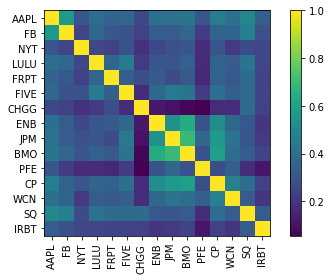

In [151]:
S = risk_models.CovarianceShrinkage(df).ledoit_wolf()

# Plotting Covariance Matrix
plotting.plot_covariance(S, plot_correlation=True);

### Conducting Monte Carlo Simulation with 50,000 combinations of portfolios to plot the Efficient Frontier

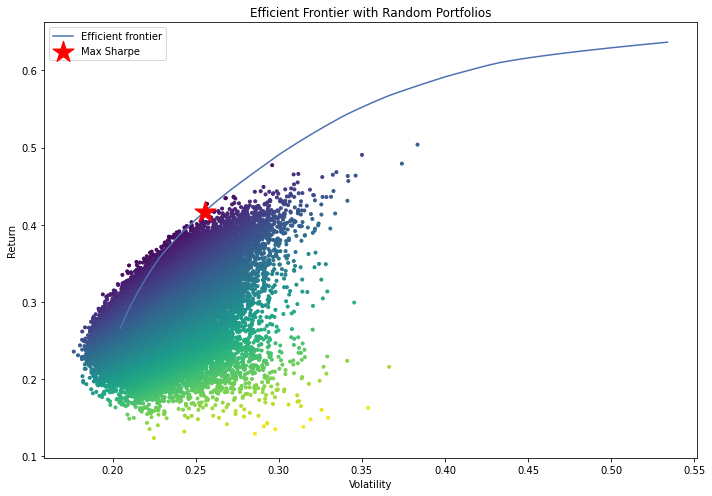

In [152]:
n_samples = 50000
w = np.random.dirichlet(alpha=np.ones(len(mu)),size=n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets/stds
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg,gamma=0.9)

fig, ax = plt.subplots(figsize=(10,7))
plotting.plot_efficient_frontier(ef,ax=ax,show_assets=False)

# Plot tangency (optimal portfolio)
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker='*', s=500, c='r', zorder=2, label='Max Sharpe')

ax.scatter(stds, rets, marker='.', c=sharpes, cmap='viridis_r')

ax.set_title('Efficient Frontier with Random Portfolios')
ax.legend()
plt.tight_layout()

plt.show()

### Detailed output of optimized portfolio with weights, expected returns/volatility, and Sharpe Ratio

OrderedDict([('AAPL', 0.13368), ('FB', 0.04005), ('NYT', 0.08194), ('LULU', 0.11036), ('FRPT', 0.15329), ('FIVE', 0.08526), ('CHGG', 0.06658), ('ENB', 0.0), ('JPM', 0.01805), ('BMO', 0.00571), ('PFE', 0.04798), ('CP', 0.04296), ('WCN', 0.0579), ('SQ', 0.15624), ('IRBT', 0.0)])
Expected annual return: 41.7%
Annual volatility: 25.5%
Sharpe Ratio: 1.55


<AxesSubplot:ylabel='None'>

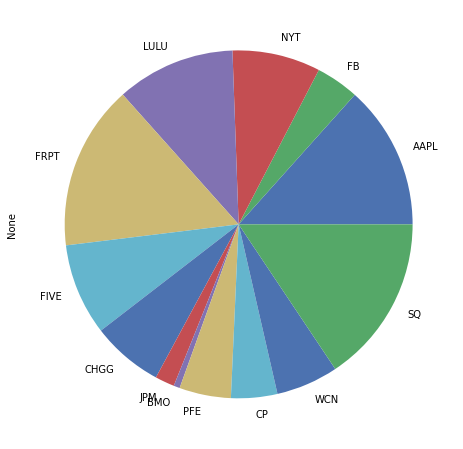

In [153]:
ef = EfficientFrontier(mu,S)
ef.add_objective(objective_functions.L2_reg,gamma=0.9)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

print(cleaned_weights)
ef.portfolio_performance(verbose=True)

pd.Series(cleaned_weights).plot.pie(figsize=(8, 8))

### Observations:

#### - The algorithm removed 2 stocks from the optimized portfolio (ENB and IRBT); this was mostly due to their lower-than-average historical returns  
#### - The top-3 stocks (SQ, FRPT, AAPL) account for approx. 44% of the optimized portfolio
#### - Any optimization problem follows the principle "Garbage in garbage out" - this algorithm is no different and is highly sensitive to changes in the method of calculating expected returns and covariance